# Traditional Neural Networks on Preprocessed Event Features
This notebook uses preprocessed data from `data/processed` (generated by `preprocess_data.py`).
We:
- Load `X_train/X_val/X_test` and `y_*` (one-hot labels)
- Reconstruct images with 2 channels (positive/negative time surface)
- Visualize sample images
- Train a neural network and evaluate on the test set.
- We evaluate following architectures:
    - Convolutional NN (CNN)
    - Simple Vision Transformer (ViT)
    - weiter TODO
    - 

In [1]:
# Setup / Imports
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Make `models/...` importable (notebook is in notebooks/traditionalNN/)
sys.path.insert(0, str(Path('..').resolve()))
sys.path.insert(0, str(Path('../..').resolve()))

from models.preprocessing import load_preprocessed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))


2026-01-20 21:41:36.918916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-20 21:41:37.083399: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-20 21:41:37.098499: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-01-20 21:41:37.099788: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

Num GPUs Available:  []


2026-01-20 21:41:38.741162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-20 21:41:38.745003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-01-20 21:41:38.745055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2026-01-20 21:41:38.745388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2026-01-20 21:41:38.745418: W tensorflow/c

In [2]:
# Load data
data_dir = Path('../../data/processed')
splits, class_names = load_preprocessed(data_dir)
X_train, y_train = splits['train']
X_val, y_val = splits['val']
X_test, y_test = splits['test']

print('Class names:', class_names)
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_val:  ', X_val.shape, 'y_val:  ', y_val.shape)
print('X_test: ', X_test.shape, 'y_test: ', y_test.shape)

n_features = X_train.shape[1]
n_classes = y_train.shape[1]
print('n_features:', n_features)
print('n_classes :', n_classes)

# Reconstruct image with 2 channels from feature vector.
# In models/preprocessing.py: time_surface -> concat([surface_pos.flatten(), surface_neg.flatten()])
if n_features % 2 != 0:
    raise ValueError(f'Exprected even number of features (pos+neg), got: {n_features}')

hw = n_features // 2
# Count samples per class
class_counts = np.sum(y_train, axis=0).astype(int)
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {class_counts[i]} samples')
print(f'Total: {np.sum(class_counts)} samples')

known_shapes = {
    640 * 480: (480, 640),
    64 * 48: (48, 64),
    320 * 240: (240, 320),
}
if hw not in known_shapes:
    raise ValueError(
        f'Unknown image size: hw={hw}. '
        'Adjust known_shapes or change preprocessing to ensure width/height are known.'
    )
H, W = known_shapes[hw]
print('Reconstructed image shape:', (H, W, 2))

Loaded train: X=(2121, 614400), y=(2121, 5)
Loaded val: X=(607, 614400), y=(607, 5)
Loaded test: X=(304, 614400), y=(304, 5)
Loaded class names: ['mark', 'marvin', 'yannes', 'unknown', 'stale']
Class names: ['mark', 'marvin', 'yannes', 'unknown', 'stale']
X_train: (2121, 614400) y_train: (2121, 5)
X_val:   (607, 614400) y_val:   (607, 5)
X_test:  (304, 614400) y_test:  (304, 5)
n_features: 614400
n_classes : 5
mark: 392 samples
marvin: 497 samples
yannes: 415 samples
unknown: 393 samples
stale: 424 samples
Total: 2121 samples
Reconstructed image shape: (480, 640, 2)


In [3]:
# Filter to keep only 'yannes', 'marvin', 'mark', 'unknown' and 'stale' classes
keep_classes = ['yannes', 'marvin', 'mark','unknown','stale']
keep_indices = [class_names.index(c) for c in keep_classes]

# Filter training data
train_mask = np.isin(np.argmax(y_train, axis=1), keep_indices)
X_train = X_train[train_mask]
y_train = y_train[train_mask][:, keep_indices]

# Filter validation data
val_mask = np.isin(np.argmax(y_val, axis=1), keep_indices)
X_val = X_val[val_mask]
y_val = y_val[val_mask][:, keep_indices]

# Filter test data
test_mask = np.isin(np.argmax(y_test, axis=1), keep_indices)
X_test = X_test[test_mask]
y_test = y_test[test_mask][:, keep_indices]

# Update class_names and n_classes
class_names = keep_classes
n_classes = len(class_names)

print('Filtered class names:', class_names)
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_val:  ', X_val.shape, 'y_val:  ', y_val.shape)
print('X_test: ', X_test.shape, 'y_test: ', y_test.shape)
print('n_classes:', n_classes)

# Count samples per class
class_counts = np.sum(y_train, axis=0).astype(int)
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {class_counts[i]} samples')
print(f'Total: {np.sum(class_counts)} samples')

Filtered class names: ['yannes', 'marvin', 'mark', 'unknown', 'stale']
X_train: (2121, 614400) y_train: (2121, 5)
X_val:   (607, 614400) y_val:   (607, 5)
X_test:  (304, 614400) y_test:  (304, 5)
n_classes: 5
yannes: 415 samples
marvin: 497 samples
mark: 392 samples
unknown: 393 samples
stale: 424 samples
Total: 2121 samples


In [4]:
# Memory cleanup (remove original splits, masks, and temporary variables)
import gc

for _name in [
    'splits', 'train_mask', 'val_mask', 'test_mask', 'class_counts',
    'keep_indices', 'keep_classes',
    'X_train_full', 'y_train_full', 'X_val_full', 'y_val_full', 'X_test_full', 'y_test_full',
    'X_train_orig', 'y_train_orig', 'X_val_orig', 'y_val_orig', 'X_test_orig', 'y_test_orig',
    'X_train_before', 'y_train_before', 'X_val_before', 'y_val_before', 'X_test_before', 'y_test_before',
    'X_train_all', 'y_train_all', 'X_val_all', 'y_val_all', 'X_test_all', 'y_test_all',
    'X_train_raw', 'y_train_raw', 'X_val_raw', 'y_val_raw', 'X_test_raw', 'y_test_raw',
]:
    if _name in globals():
        del globals()[_name]

gc.collect()
print('Memory cleanup completed.')

Memory cleanup completed.


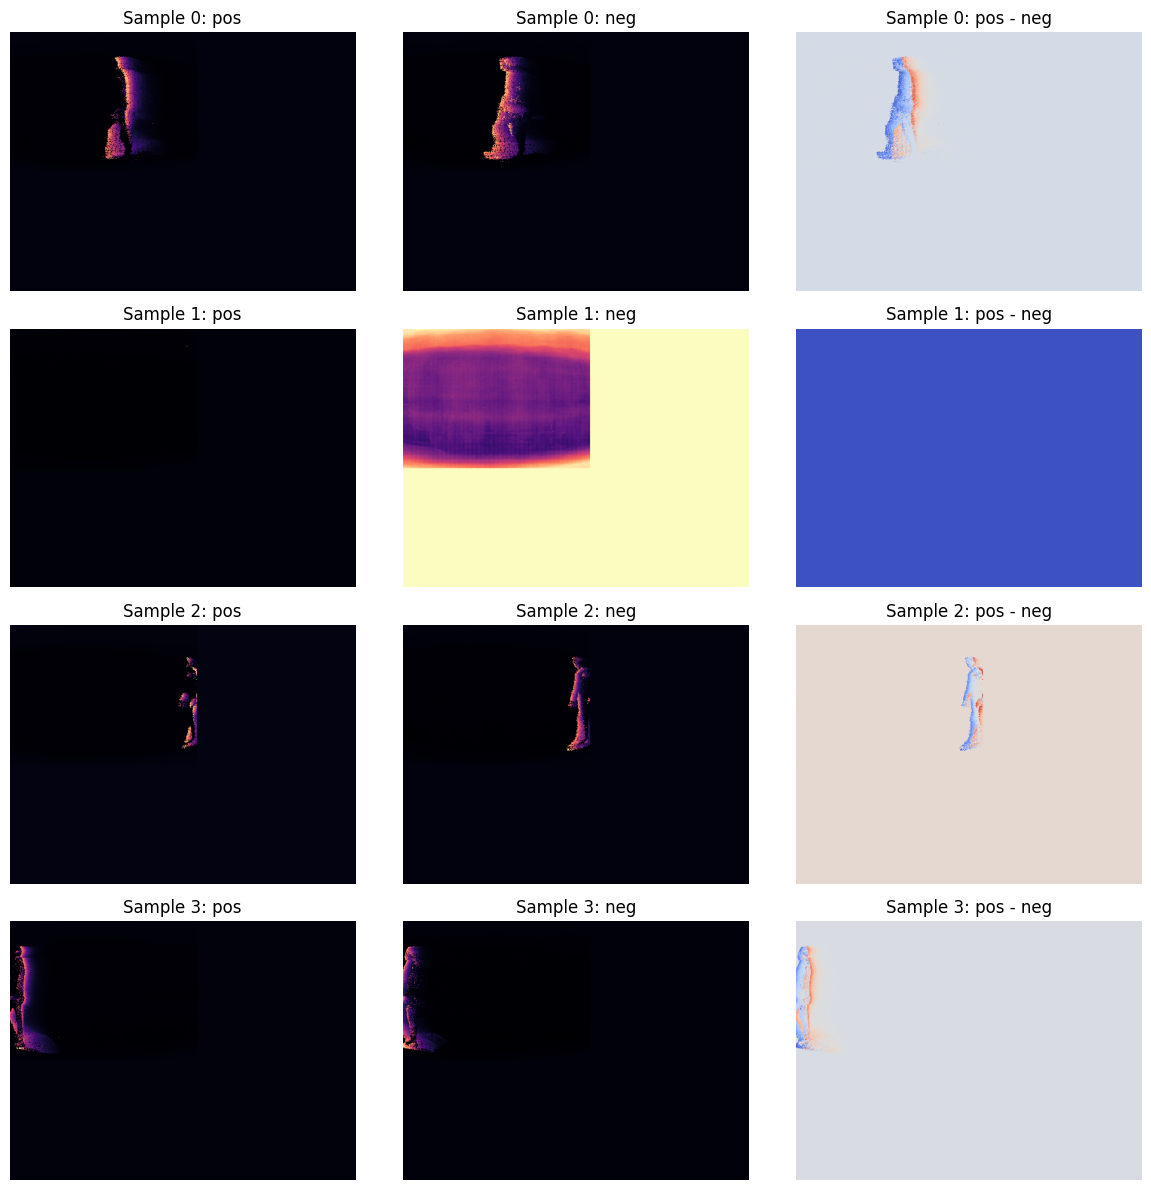

In [5]:
# Quick visualization (a few samples)
def vector_to_image_np(x_vec: np.ndarray, H: int, W: int) -> np.ndarray:
    x_vec = np.asarray(x_vec)
    hw = H * W
    pos = x_vec[:hw].reshape(H, W)
    neg = x_vec[hw:hw*2].reshape(H, W)
    img = np.stack([pos, neg], axis=-1)  # (H, W, 2)
    return img

n_show = min(4, len(X_train))
fig, axes = plt.subplots(n_show, 3, figsize=(12, 3 * n_show))
if n_show == 1:
    axes = np.expand_dims(axes, axis=0)

for i in range(n_show):
    img = vector_to_image_np(X_train[i], H, W)
    pos = img[..., 0]
    neg = img[..., 1]
    diff = pos - neg
    axes[i, 0].imshow(pos, cmap='magma')
    axes[i, 0].set_title(f'Sample {i}: pos')
    axes[i, 1].imshow(neg, cmap='magma')
    axes[i, 1].set_title(f'Sample {i}: neg')
    axes[i, 2].imshow(diff, cmap='coolwarm')
    axes[i, 2].set_title(f'Sample {i}: pos - neg')
    for j in range(3):
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# tf.data Pipeline: Vector -> (H,W,2) without large copies
AUTOTUNE = tf.data.AUTOTUNE

def to_image_tf(x_vec, y):
    x_vec = tf.cast(x_vec, tf.float32)
    hw = H * W
    pos = tf.reshape(x_vec[:hw], (H, W, 1))
    neg = tf.reshape(x_vec[hw:hw*2], (H, W, 1))
    img = tf.concat([pos, neg], axis=-1)  # (H, W, 2)
    y = tf.cast(y, tf.float32)
    return img, y

batch_size = 16
ds_train = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(min(len(X_train), 2000), seed=42, reshuffle_each_iteration=True)
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
ds_val = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
ds_test = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


# Sanity check: one batch
x_b, y_b = next(iter(ds_train))
print('Batch X:', x_b.shape, 'Batch y:', y_b.shape)


2026-01-20 21:42:15.546245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Batch X: (16, 480, 640, 2) Batch y: (16, 5)


In [7]:
# Clean up original data arrays to free memory before training
del X_train
del y_train
del X_test
del y_test
del X_val
del y_val
gc.collect()

5

---
# Model Variants

The following blocks are **modular and interchangeable**. Run only **one** of the model blocks before starting training.

## Overview:
1. **Configuration** - Central hyperparameters (always run first)
2. **Data Augmentation** - Verbesserte Datenpipeline
3. **Learning Rate Scheduler** - Warmup + Cosine Decay
4. **Verbesserter Transformer** - More capacity, mehr Regularization
5. **CLS-Token Transformer** - With classification token instead of global pooling
6. **Relative Positional Encoding** - Lernbare relative Positionen
7. **Hybrid CNN-Transformer** - Convolutional stem + Transformer

## 1. Central Configuration
Run this block **first**. All hyperparameters are defined here.

In [9]:
# ============================================================================
# CENTRAL CONFIGURATION - OPTIMIZEDn
# ============================================================================

class Config:
    """Central hyperparameter configuration - OPTIMIZED"""
    
    # Image parameters - INCREASED like simple_cnn_large
    target_h = 192       # increased from 96 (doubled)
    target_w = 256       # increased from 128 (doubled)
    
    # Patch embedding - larger patches for same token count
    patch_size = 16      # increased from 8 (to keep token number constant)
    
    # Transformer architecture (for small datasets)
    embed_dim = 256      # keeped
    num_heads = 8        # keeped
    mlp_dim = 512        # keeped
    num_blocks = 4       # reduce from 6 (less overfitting)
    
    # Regularization (with strong regularization)
    dropout = 0.25       # increased from 0.2
    attention_dropout = 0.15  # increased from 0.1
    mlp_dropout = 0.25   # increased from 0.2
    stochastic_depth_rate = 0.15  # increased from 0.1
    
    # Training
    batch_size = 16
    epochs = 200
    initial_lr = 1e-4
    weight_decay = 0.01
    label_smoothing = 0.1
    
    # LR Scheduler
    warmup_epochs = 10
    
    # Early Stopping
    patience = 15
    
    @property
    def num_patches(self):
        return (self.target_h // self.patch_size) * (self.target_w // self.patch_size)

cfg = Config()
print(f"Number of patches/tokens: {cfg.num_patches}")
print(f"Embed Dim: {cfg.embed_dim}, Heads: {cfg.num_heads}, Blocks: {cfg.num_blocks}")
print(f"Dropout: {cfg.dropout}, Attention Dropout: {cfg.attention_dropout}")
print(f"Resolution: {cfg.target_h}x{cfg.target_w} (like simple_cnn_large)")

Number of patches/tokens: 192
Embed Dim: 256, Heads: 8, Blocks: 4
Dropout: 0.25, Attention Dropout: 0.15
Resolution: 192x256 (like simple_cnn_large)


## 2. Simple CNN Large
Classic CNN without transformer components, with higher resolution.

In [10]:
# ============================================================================
# SIMPLE CNN WITH LARGER IMAGE SIZE 
# ============================================================================

def create_simple_cnn_large():
    """
    Simple CNN with higher resolution (192x256).
    No transformer components, classic ConvNet architecture.
    """
    target_h_large = 192  # twice as large as transformer
    target_w_large = 256
    
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(target_h_large, target_w_large)(inp)
    
    # Conv Block 1: 192x256 -> 96x128
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Conv Block 2: 96x128 -> 48x64
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Conv Block 3: 48x64 -> 24x32
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Conv Block 4: 24x32 -> 12x16
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='simple_cnn_large')

# Create model
model_simple_cnn = create_simple_cnn_large()

model_simple_cnn.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_simple_cnn.summary()
print(f"\nParameter: {model_simple_cnn.count_params():,}")

Model: "simple_cnn_large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 640, 2)]     0         
                                                                 
 resizing (Resizing)         (None, 192, 256, 2)       0         
                                                                 
 conv2d (Conv2D)             (None, 192, 256, 32)      608       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 128, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 96, 128, 32)       0         
                                                  

## 3. Basic Transformer VIT
A simple Vision Transformer (ViT) implementation with CNN-Stem for improved local feature extraction.
This model uses patch embedding with positional encoding and multiple transformer blocks.

In [11]:
# ============================================================================
# BASIC TRANSFORMER VIT  (like simple_cnn_large)
# ============================================================================

# Higher resolution like simple_cnn_large
target_h, target_w = 192, 256   # erhöht von 96x128
patch = 16                      # larger patches (192/16=12, 256/16=16 => 192 tokens)
embed_dim = 256                 # erhöht von 128
num_heads = 8                   # erhöht von 4
mlp_dim = 512                   # erhöht von 256
num_blocks = 4                  # reduziert for less overfitting
dropout = 0.25                  # erhöht von 0.1

def cnn_stem(x):
    """CNN-Stem for local feature extraction before the Transformer"""
    # Block 1: lernt lokale patterns
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 2: komplexere patterns
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    return x

def transformer_block(x):
    # Self-Attention
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads,
        dropout=dropout,
    )(y, y)
    x = layers.Add()([x, y])

    # MLP
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(mlp_dim, activation='gelu')(y)
    y = layers.Dropout(dropout)(y)
    y = layers.Dense(embed_dim)(y)
    y = layers.Dropout(dropout)(y)
    x = layers.Add()([x, y])
    return x

inp = layers.Input(shape=(H, W, 2))
x = layers.Resizing(target_h, target_w)(inp)

# CNN stem for better local features (based on simple_cnn_large)
x = cnn_stem(x)
# After CNN-Stem: 192/4=48, 256/4=64

# Patch embedding on CNN features
x = layers.Conv2D(embed_dim, kernel_size=4, strides=4, padding='valid')(x)
# (B, 12, 16, embed_dim) -> (B, N, embed_dim)
x = layers.Reshape((-1, embed_dim))(x)

# Positional Embedding
num_patches = 12 * 16  # 192 Tokens
pos = tf.range(start=0, limit=num_patches, delta=1)
pos_emb = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(pos)
x = x + pos_emb
x = layers.Dropout(dropout)(x)

for _ in range(num_blocks):
    x = transformer_block(x)

x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)  # higher dropout before output like simple_cnn_large
out = layers.Dense(n_classes, activation='softmax')(x)

model_basic_transformer = keras.Model(inp, out, name='basic_transformer_vit')

model_basic_transformer.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=["accuracy"],
)
model_basic_transformer.summary()
print(f"\nImprovements: CNN-Stem, 192x256, Dropout=0.25/0.5, 4 blocks")

Model: "basic_transformer_vit"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing_1 (Resizing)          (None, 192, 256, 2)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 192, 256, 32  608         ['resizing_1[0][0]']             
                                )                                                                 
                                                                              

## 4. Improved Transformer
More capacity + Stochastic Depth + Attention Dropout. Uses Global Average Pooling.

In [12]:
# ============================================================================
# IMPROVED TRANSFORMER - With CNN-Stem and Stochastic Depth
# ============================================================================


class StochasticDepth(layers.Layer):
    """
    Stochastic Depth / Drop Path Layer.
    Random skipping of residual blocks during training.
    """

    def __init__(self, drop_prob=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        if not training or self.drop_prob == 0.0:
            return x

        keep_prob = 1 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,) * (len(x.shape) - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, dtype=x.dtype)
        binary_tensor = tf.floor(random_tensor)
        return (x / keep_prob) * binary_tensor

    def get_config(self):
        config = super().get_config()
        config.update({"drop_prob": self.drop_prob})
        return config


def create_improved_transformer():
    """Creates an improved Transformer mit CNN-Stem (like simple_cnn_large)"""

    # Berechne Drop-Path-Rate pro Block (linear ansteigend)
    drop_rates = [cfg.stochastic_depth_rate * i / max(1, cfg.num_blocks - 1) for i in range(cfg.num_blocks)]

    def cnn_stem(x):
        """CNN-Stem for local feature extraction (based on simple_cnn_large)"""
        # Block 1
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        
        # Block 2
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        return x

    def transformer_block_improved(x, drop_rate=0.0):
        # Self-Attention mit Attention Dropout
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.MultiHeadAttention(
            num_heads=cfg.num_heads,
            key_dim=cfg.embed_dim // cfg.num_heads,
            dropout=cfg.attention_dropout,
        )(y, y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])

        # MLP mit erhöhtem Dropout
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(cfg.mlp_dim, activation="gelu")(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = layers.Dense(cfg.embed_dim)(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        return x

    # Input
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(cfg.target_h, cfg.target_w)(inp)

    # CNN-Stem for local features (NEW!)
    x = cnn_stem(x)
    # After CNN-Stem: 192/4=48, 256/4=64

    # Patch embedding on CNN features (smaller patches since already downsampled)
    x = layers.Conv2D(cfg.embed_dim, kernel_size=4, strides=4, padding="valid")(x)
    x = layers.Reshape((-1, cfg.embed_dim))(x)
    # (B, 12, 16, embed_dim) -> (B, 192, embed_dim)

    # Positional Embedding
    num_tokens = 12 * 16  # 192 Tokens
    pos = tf.range(start=0, limit=num_tokens, delta=1)
    pos_emb = layers.Embedding(input_dim=num_tokens, output_dim=cfg.embed_dim)(pos)
    x = x + pos_emb

    # Dropout nach Embedding
    x = layers.Dropout(cfg.dropout)(x)

    # Transformer blocks with Stochastic Depth
    for i in range(cfg.num_blocks):
        x = transformer_block_improved(x, drop_rates[i])

    # Classification Head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)  # higher dropout before output
    out = layers.Dense(n_classes, activation="softmax")(x)

    return keras.Model(inp, out, name="improved_transformer_cnn")


# Create model
model_improved_transformer = create_improved_transformer()

# Compile with AdamW and LR schedule
model_improved_transformer.compile(
    optimizer=keras.optimizers.Adam(weight_decay=cfg.weight_decay),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=cfg.label_smoothing),
    metrics=["accuracy"],
)

model_improved_transformer.summary()
print(f"\nParameter: {model_improved_transformer.count_params():,}")
print(f"Improvements: CNN-Stem, 192x256, Dropout=0.25/0.5, Stochastic Depth")

Model: "improved_transformer_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing_2 (Resizing)          (None, 192, 256, 2)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 192, 256, 32  608         ['resizing_2[0][0]']             
                                )                                                                 
                                                                           

## 5. CLS-Token Transformer
Classical ViT approach with a dedicated classification token instead of global average pooling.

In [14]:
# ============================================================================
# CLS-TOKEN TRANSFORMER  
# ============================================================================

class CLSToken(layers.Layer):
    """
    Fügt einen lernbaren CLS-Token am Anfang der Sequenz hinzu.
    The CLS token aggregates global information for classification.
    """
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
    
    def build(self, input_shape):
        self.cls_token = self.add_weight(
            name='cls_token',
            shape=(1, 1, self.embed_dim),
            initializer='zeros',
            trainable=True
        )
        super().build(input_shape)
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, self.embed_dim])
        return tf.concat([cls_tokens, x], axis=1)
    
    def get_config(self):
        config = super().get_config()
        config.update({'embed_dim': self.embed_dim})
        return config

def create_cls_token_transformer():
    """Creates a Transformer mit CLS-Token and CNN-Stem"""
    
    drop_rates = [cfg.stochastic_depth_rate * i / max(1, cfg.num_blocks - 1) 
                  for i in range(cfg.num_blocks)]
    
    def cnn_stem(x):
        """CNN-Stem for local feature extraction"""
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        return x
    
    def transformer_block_v2(x, drop_rate=0.0):
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.MultiHeadAttention(
            num_heads=cfg.num_heads,
            key_dim=cfg.embed_dim // cfg.num_heads,
            dropout=cfg.attention_dropout,
        )(y, y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(cfg.mlp_dim, activation='gelu')(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = layers.Dense(cfg.embed_dim)(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        return x
    
    # Input
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(cfg.target_h, cfg.target_w)(inp)
    
    # CNN-Stem for local features (NEW!)
    x = cnn_stem(x)
    # After CNN-Stem: 192/4=48, 256/4=64
    
    # Patch embedding on CNN features
    x = layers.Conv2D(cfg.embed_dim, kernel_size=4, strides=4, padding='valid')(x)
    x = layers.Reshape((-1, cfg.embed_dim))(x)
    
    # CLS Token hinzufügen (vor Positional Embedding!)
    x = CLSToken(cfg.embed_dim)(x)
    
    # Positional Embedding (+1 for CLS token)
    num_tokens = 12 * 16 + 1  # 192 + 1 for CLS
    pos = tf.range(start=0, limit=num_tokens, delta=1)
    pos_emb = layers.Embedding(input_dim=num_tokens, output_dim=cfg.embed_dim)(pos)
    x = x + pos_emb
    
    x = layers.Dropout(cfg.dropout)(x)
    
    # Transformer blocks
    for i in range(cfg.num_blocks):
        x = transformer_block_v2(x, drop_rates[i])
    
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # NUR den CLS-Token for classification nutzen (Index 0)
    cls_output = x[:, 0, :]  # (batch, embed_dim)
    
    x = layers.Dropout(0.5)(cls_output)  # higher dropout before output
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='cls_token_transformer_cnn')

model_cls_transformer = create_cls_token_transformer()

model_cls_transformer.compile(
    optimizer=keras.optimizers.Adam(
        weight_decay=cfg.weight_decay
    ),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=cfg.label_smoothing),
    metrics=['accuracy'],
)

model_cls_transformer.summary()
print(f"\nParameter: {model_cls_transformer.count_params():,}")
print("Improvements: CNN-Stem, 192x256, Dropout=0.25/0.5")

Model: "cls_token_transformer_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing_3 (Resizing)          (None, 192, 256, 2)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 192, 256, 32  608         ['resizing_3[0][0]']             
                                )                                                                 
                                                                          

## 6. Relative Positional Encoding Transformer
Uses 2D relative positions instead of absolute, which is better for spatial relationships.

In [15]:
# ============================================================================
# RELATIVE POSITIONAL ENCODING TRANSFORMER  
# ============================================================================

class RelativePositionalEncoding2D(layers.Layer):
    """
    2D Relative Positional Encoding.
    Lernt relative Positionen zwischen Patches sowohl in x als auch y-Richtung.
    """
    def __init__(self, num_patches_h, num_patches_w, embed_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.num_patches_h = num_patches_h
        self.num_patches_w = num_patches_w
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.relative_position_bias_table_size = (2 * num_patches_h - 1) * (2 * num_patches_w - 1)
    
    def build(self, input_shape):
        self.relative_position_bias_table = self.add_weight(
            name='relative_position_bias_table',
            shape=(self.relative_position_bias_table_size, self.num_heads),
            initializer='truncated_normal',
            trainable=True
        )
        
        coords_h = np.arange(self.num_patches_h)
        coords_w = np.arange(self.num_patches_w)
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = coords.reshape(2, -1)
        
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose(1, 2, 0)
        
        relative_coords[:, :, 0] += self.num_patches_h - 1
        relative_coords[:, :, 1] += self.num_patches_w - 1
        relative_coords[:, :, 0] *= 2 * self.num_patches_w - 1
        
        relative_position_index = relative_coords.sum(-1)
        self.relative_position_index = tf.constant(relative_position_index.flatten(), dtype=tf.int32)
        
        super().build(input_shape)
    
    def call(self, attention_scores):
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, 
            self.relative_position_index
        )
        num_patches = self.num_patches_h * self.num_patches_w
        relative_position_bias = tf.reshape(
            relative_position_bias, 
            [num_patches, num_patches, self.num_heads]
        )
        relative_position_bias = tf.transpose(relative_position_bias, [2, 0, 1])
        return attention_scores + relative_position_bias[None, :, :, :]
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_patches_h': self.num_patches_h,
            'num_patches_w': self.num_patches_w,
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
        })
        return config

class RelativeAttention(layers.Layer):
    """Multi-Head Attention with Relative Positional Encoding"""
    def __init__(self, embed_dim, num_heads, num_patches_h, num_patches_w, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.dropout_rate = dropout
        
        self.qkv = layers.Dense(embed_dim * 3, use_bias=True)
        self.proj = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(dropout)
        
        self.rel_pos = RelativePositionalEncoding2D(
            num_patches_h, num_patches_w, embed_dim, num_heads
        )
    
    def call(self, x, training=None):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        
        qkv = self.qkv(x)
        qkv = tf.reshape(qkv, [batch_size, seq_len, 3, self.num_heads, self.head_dim])
        qkv = tf.transpose(qkv, [2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        attn = self.rel_pos(attn)
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.dropout(attn, training=training)
        
        out = tf.matmul(attn, v)
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, [batch_size, seq_len, self.embed_dim])
        out = self.proj(out)
        
        return out

def create_relative_pos_transformer():
    """Transformer with 2D relative positional encoding."""
    
    # After CNN-Stem: 192/4=48, 256/4=64, then /4 for patches -> 12x16
    num_patches_h = 12
    num_patches_w = 16
    
    drop_rates = [cfg.stochastic_depth_rate * i / max(1, cfg.num_blocks - 1) 
                  for i in range(cfg.num_blocks)]
    
    def cnn_stem(x):
        """CNN-Stem for local feature extraction"""
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        return x
    
    def transformer_block_rel(x, drop_rate=0.0, block_idx=0):
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = RelativeAttention(
            cfg.embed_dim, cfg.num_heads, 
            num_patches_h, num_patches_w,
            dropout=cfg.attention_dropout,
            name=f'rel_attn_{block_idx}'
        )(y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(cfg.mlp_dim, activation='gelu')(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = layers.Dense(cfg.embed_dim)(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        return x
    
    # Input
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(cfg.target_h, cfg.target_w)(inp)
    
    # CNN-Stem (NEW!)
    x = cnn_stem(x)
    
    # Patch embedding on CNN features
    x = layers.Conv2D(cfg.embed_dim, kernel_size=4, strides=4, padding='valid')(x)
    x = layers.Reshape((-1, cfg.embed_dim))(x)
    
    x = layers.Dropout(cfg.dropout)(x)
    
    # Transformer blocks with relative positional attention
    for i in range(cfg.num_blocks):
        x = transformer_block_rel(x, drop_rates[i], block_idx=i)
    
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)  # higher dropout before output
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='relative_pos_transformer_cnn')

# Create model
model_relative_pos = create_relative_pos_transformer()

model_relative_pos.compile(
    optimizer=keras.optimizers.Adam(
        weight_decay=cfg.weight_decay
    ),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=cfg.label_smoothing),
    metrics=['accuracy'],
)

model_relative_pos.summary()
print(f"\nParameter: {model_relative_pos.count_params():,}")
print("Improvements: CNN-Stem, 192x256, Dropout=0.25/0.5")

Model: "relative_pos_transformer_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing_4 (Resizing)          (None, 192, 256, 2)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 192, 256, 32  608         ['resizing_4[0][0]']             
                                )                                                                 
                                                                       

## 7. Hybrid CNN-Transformer
Combines a CNN stem for local feature extraction with transformer blocks for global attention.
Often the best choice for smaller datasets!

In [16]:
# ============================================================================
# HYBRID CNN-TRANSFORMER 
# ============================================================================

def create_hybrid_cnn_transformer():
    """
    Hybrid-Architektur mit verbessertem CNN-Stem (like simple_cnn_large).
    CNN for local features, Transformer for global attention.
    """
    
    drop_rates = [cfg.stochastic_depth_rate * i / max(1, cfg.num_blocks - 1) 
                  for i in range(cfg.num_blocks)]
    
    def transformer_block_hybrid(x, drop_rate=0.0):
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.MultiHeadAttention(
            num_heads=cfg.num_heads,
            key_dim=cfg.embed_dim // cfg.num_heads,
            dropout=cfg.attention_dropout,
        )(y, y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(cfg.mlp_dim, activation='gelu')(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = layers.Dense(cfg.embed_dim)(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        return x
    
    # Input
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(cfg.target_h, cfg.target_w)(inp)
    
    # =========== CNN STEM (like simple_cnn_large) ===========
    # Block 1: 192x256 -> 96x128
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 2: 96x128 -> 48x64
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 3: 48x64 -> 24x32
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 4: 24x32 -> 12x16 (Projection zu embed_dim)
    x = layers.Conv2D(cfg.embed_dim, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(cfg.embed_dim, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # =========== TRANSFORMER ===========
    # Reshape zu Sequenz: (B, 12, 16, embed_dim) -> (B, 192, embed_dim)
    feature_h = cfg.target_h // 16  # nach 4x stride=2 -> 12
    feature_w = cfg.target_w // 16  # -> 16
    num_tokens = feature_h * feature_w  # 192
    
    x = layers.Reshape((num_tokens, cfg.embed_dim))(x)
    
    # Positional Embedding
    pos = tf.range(start=0, limit=num_tokens, delta=1)
    pos_emb = layers.Embedding(input_dim=num_tokens, output_dim=cfg.embed_dim)(pos)
    x = x + pos_emb
    
    x = layers.Dropout(cfg.dropout)(x)
    
    # Transformer blocks (fewer needed due to strong CNN stem)
    num_transformer_blocks = 2  # 2 transformer blocks
    for i in range(num_transformer_blocks):
        drop_rate = drop_rates[i] if i < len(drop_rates) else drop_rates[-1]
        x = transformer_block_hybrid(x, drop_rate)
    
    # Classification Head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)  # higher dropout before output
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='hybrid_cnn_transformer')

# Create model
model_hybrid_cnn = create_hybrid_cnn_transformer()

model_hybrid_cnn.compile(
    optimizer=keras.optimizers.Adam(
        weight_decay=cfg.weight_decay
    ),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=cfg.label_smoothing),
    metrics=['accuracy'],
)

model_hybrid_cnn.summary()
print(f"\nParameter: {model_hybrid_cnn.count_params():,}")
print("Improvements: 4-Block CNN-Stem (like simple_cnn_large), 192x256, Dropout=0.25/0.5")

Model: "hybrid_cnn_transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing_5 (Resizing)          (None, 192, 256, 2)  0           ['input_6[0][0]']                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 192, 256, 32  608         ['resizing_5[0][0]']             
                                )                                                                 
                                                                             

## 8. LSTM Model
Treats the image as a sequence of rows and uses LSTM for temporal patterns.

In [17]:
# ============================================================================
# LSTM MODEL 
# ============================================================================

def create_lstm_model():
    """
    LSTM-based model with higher resolution.
    Treats the image as a sequence of rows (H time steps, W*2 features).
    """
    # Higher resolution like simple_cnn_large
    target_h_lstm = 192
    target_w_lstm = 256
    
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(target_h_lstm, target_w_lstm)(inp)
    
    # Reshape: (B, H, W, 2) -> (B, H, W*2) - jede Zeile ist ein Zeitschritt
    x = layers.Reshape((target_h_lstm, target_w_lstm * 2))(x)
    
    # Bidirectional LSTM with more units
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.25)(x)  # Dropout like simple_cnn_large
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.25)(x)
    
    # Classification Head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # higher dropout before output
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='lstm_model')

# Create model
model_lstm = create_lstm_model()

model_lstm.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_lstm.summary()
print(f"\nParameter: {model_lstm.count_params():,}")
print("Improvements: 192x256, Dropout=0.25/0.5, larger dense layer")

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 480, 640, 2)]     0         
                                                                 
 resizing_6 (Resizing)       (None, 192, 256, 2)       0         
                                                                 
 reshape_5 (Reshape)         (None, 192, 512)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 192, 256)         656384    
 l)                                                              
                                                                 
 dropout_67 (Dropout)        (None, 192, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                   

## 9. CNN-LSTM Combination
CNN for feature extraction, then LSTM for sequential processing. Simple without fancy optimizations.

In [18]:
# ============================================================================
# CNN-LSTM COMBINATION 
# ============================================================================

def create_cnn_lstm_model():
    """
    CNN-LSTM combination with improved CNN stem.
    CNN extracts features like simple_cnn_large, LSTM processes them sequentially.
    """
    # Higher resolution like simple_cnn_large
    target_h_cnn = 192
    target_w_cnn = 256
    
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(target_h_cnn, target_w_cnn)(inp)
    
    # CNN feature extraction (like simple_cnn_large)
    # Block 1: 192x256 -> 96x128
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 2: 96x128 -> 48x64
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 3: 48x64 -> 24x32
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 4: 24x32 -> 12x16
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Reshape for LSTM: (B, 12, 16, 256) -> (B, 12, 16*256)
    # Jede Zeile des Feature-Maps wird ein Zeitschritt
    feature_h = target_h_cnn // 16  # 12
    feature_w = target_w_cnn // 16  # 16
    x = layers.Reshape((feature_h, feature_w * 256))(x)
    
    # LSTM on CNN features
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    x = layers.Dropout(0.25)(x)
    
    # Classification Head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # higher dropout before output
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='cnn_lstm_model')

# Create model
model_cnn_lstm = create_cnn_lstm_model()

model_cnn_lstm.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_cnn_lstm.summary()
print(f"\nParameter: {model_cnn_lstm.count_params():,}")
print("Improvements: 4-Block CNN (like simple_cnn_large), 192x256, Dropout=0.25/0.5, Bidirectional LSTM")

Model: "cnn_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 480, 640, 2)]     0         
                                                                 
 resizing_7 (Resizing)       (None, 192, 256, 2)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 192, 256, 32)      608       
                                                                 
 conv2d_37 (Conv2D)          (None, 192, 256, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 96, 128, 32)      0         
 g2D)                                                            
                                                                 
 dropout_70 (Dropout)        (None, 96, 128, 32)       0         
                                                    

## 10. Training
Run this block to train the selected model.

In [20]:
# ============================================================================
# MODEL TRAINING + EVALUATION
# ============================================================================

from pathlib import Path
from datetime import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Create run directory
run_dir = Path('./runs') / f"model_compare_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
run_dir.mkdir(parents=True, exist_ok=True)
print('Run directory:', run_dir.resolve())

# Select models to train (uncomment as needed)
models_to_train = [
    model_simple_cnn,
    # model_basic_transformer,
    # model_improved_transformer,
    # model_cls_transformer,
    # model_relative_pos,
    # model_hybrid_cnn,
    # model_lstm,
    # model_cnn_lstm,
]

results = {}
trained_models = {}

for model in models_to_train:
    print(f'\n{"="*80}')
    print(f'Training: {model.name}')
    print('='*80)

    tf.keras.backend.clear_session()

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=cfg.patience,
            restore_best_weights=True,
            verbose=1,
        ),
    ]

    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=cfg.epochs,
        callbacks=callbacks,
        verbose=1,
    )

    # Save model
    model_path = run_dir / f'{model.name}.keras'
    model.save(model_path)
    print(f'Saved: {model_path.name}')

    # Evaluate on test set
    eval_out = model.evaluate(ds_test, verbose=1, return_dict=True)
    test_loss = eval_out['loss']
    test_acc = eval_out['accuracy']
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%')

    # Confusion matrix
    y_true_all, y_pred_all = [], []
    for batch_x, batch_y in ds_test:
        probs = model.predict(batch_x, verbose=0)
        y_true_all.extend(tf.argmax(batch_y, axis=1).numpy())
        y_pred_all.extend(tf.argmax(probs, axis=1).numpy())
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all)
    report = classification_report(y_true_all, y_pred_all, target_names=class_names, digits=4)

    # Plot training curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history.history.get('accuracy', []), label='train')
    axes[0].plot(history.history.get('val_accuracy', []), label='val')
    axes[0].set_title(f'{model.name} - Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history.get('loss', []), label='train')
    axes[1].plot(history.history.get('val_loss', []), label='val')
    axes[1].set_title(f'{model.name} - Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(run_dir / f'{model.name}_curves.png', dpi=150)
    plt.show()

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{model.name} - Confusion Matrix')
    plt.tight_layout()
    plt.savefig(run_dir / f'{model.name}_confusion.png', dpi=150)
    plt.show()

    # Store results
    best_val_acc = max(history.history.get('val_accuracy', [0]))
    results[model.name] = {
        'test_acc': test_acc,
        'test_loss': test_loss,
        'best_val_acc': best_val_acc,
        'epochs': len(history.history.get('loss', [])),
        'confusion_matrix': cm.tolist(),
        'classification_report': report,
    }
    trained_models[model.name] = model

    # Save results
    with open(run_dir / f'{model.name}_results.json', 'w') as f:
        json.dump({k: v for k, v in results[model.name].items() if k != 'confusion_matrix'}, f, indent=2)

# Summary
print('\n' + '='*80)
print('RESULTS SUMMARY')
print('='*80)
for name, res in sorted(results.items(), key=lambda x: -x[1]['test_acc']):
    print(f"{name:30s} | test_acc={res['test_acc']:.4f} | test_loss={res['test_loss']:.4f} | best_val_acc={res['best_val_acc']:.4f}")

# Save summary
with open(run_dir / 'summary.json', 'w') as f:
    json.dump({k: {kk: vv for kk, vv in v.items() if kk != 'classification_report'} for k, v in results.items()}, f, indent=2)

print(f'\nModels saved: {[f.name for f in run_dir.glob("*.keras")]}')


Run directory: /home/yannes/Documents/neuroAi/notebooks/traditionalNN/runs/model_compare_20260120_214835

Training: simple_cnn_large
Epoch 1/200
  5/133 [>.............................] - ETA: 1:04 - loss: 1.1413 - accuracy: 0.5500

KeyboardInterrupt: 

=== Model Comparison ===
simple_cnn_large | test_acc=0.9309 | test_loss=0.2671 | best_val_acc=0.9654 | epochs=62


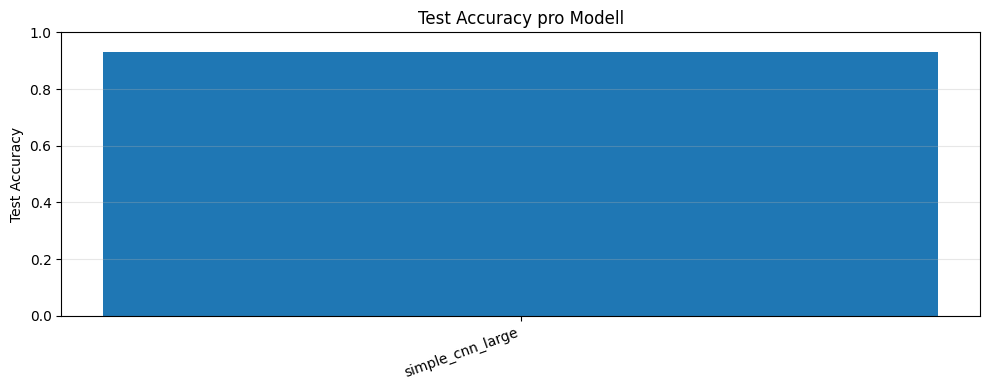

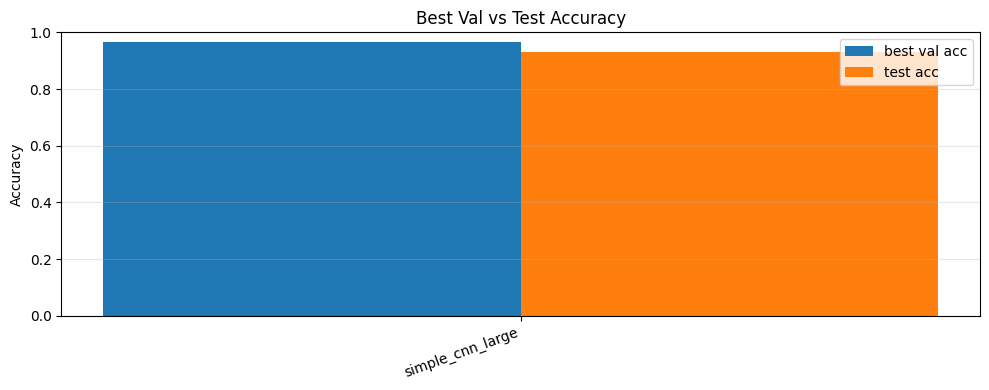

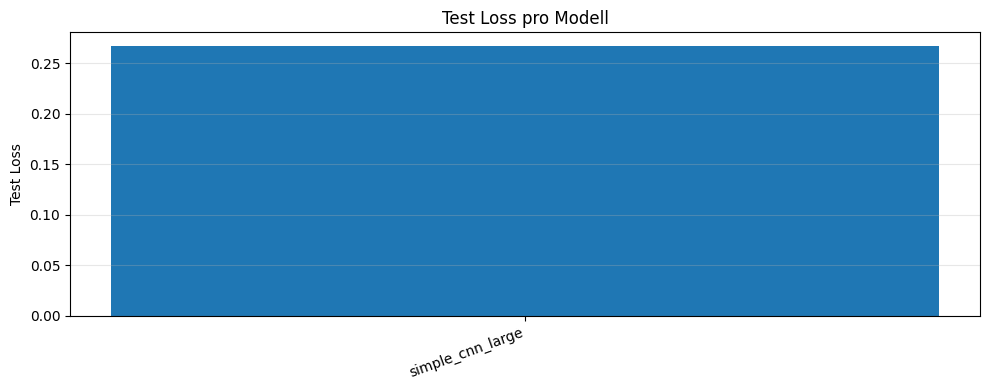


Tipp: Alle Artefakte (Modelle, Kurven, Confusion Matrices, Reports) liegen im run_dir aus Zelle 19.


In [11]:
# ============================================================================
# RESULTS COMPARISON
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt

if 'results' not in globals() or not results:
    raise RuntimeError('No results found. Run the training cell first.')

# Summary table
print('Model Comparison:')
print('-' * 90)
print(f"{'Model':<30} | {'Test Acc':>10} | {'Test Loss':>10} | {'Val Acc':>10} | {'Epochs':>6}")
print('-' * 90)
for name, res in sorted(results.items(), key=lambda x: -x[1]['test_acc']):
    print(f"{name:<30} | {res['test_acc']:>10.4f} | {res['test_loss']:>10.4f} | {res['best_val_acc']:>10.4f} | {res['epochs']:>6}")
print('-' * 90)

# Bar chart
if len(results) > 1:
    fig, ax = plt.subplots(figsize=(10, 5))
    names = list(results.keys())
    test_accs = [results[n]['test_acc'] for n in names]
    val_accs = [results[n]['best_val_acc'] for n in names]

    x = np.arange(len(names))
    width = 0.35
    ax.bar(x - width/2, test_accs, width, label='Test Accuracy')
    ax.bar(x + width/2, val_accs, width, label='Best Val Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Comparison')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
